In [35]:
import requests
import pandas as pd

### Setting matching player names and player ID lists
Player_names = [
    "Nwaneri", "Lewis-Skelly", "Saka", "Yamal", "Cubarsi", "Bernal", 
    "Fort", "Gavi", "Fati", "Balde", "Lopez", "Casado", "Garcia", "Pena", "Olmo"
]
Player_IDs = [
    1401702, 1423711, 934235, 1402912, 1402913, 1526618, 1402908, 
    1103693, 962883, 997035, 1153270, 1000483, 876214, 794949, 789071
]

### Defining the team IDs for Arsenal and Barcelona for filtering
valid_team_ids = {42, 2817}

### Defining the headers for the extraction
headers = {"User-Agent": "Mozilla/5.0"}

### List to store the individual player dataframes
all_players_data = []

for i, player_id in enumerate(Player_IDs):
    player_ratings = []
    page = 0

    while True:
        url = f"https://www.sofascore.com/api/v1/player/{player_id}/events/last/{page}"
        response = requests.get(url, headers=headers)
        data = response.json()

        ### Stop if we have run out of matches or if something else is wrong
        if not data or 'statisticsMap' not in data or not data['statisticsMap']:
            break

        ### Build lookup for event details
        events_dict = {}
        if 'events' in data:
            for event in data['events']:
                events_dict[event.get('id')] = event

        ### Processing each event to get rating
        for event_id_str, stats in data['statisticsMap'].items():
            try:
                event_id = int(event_id_str)
            except ValueError:
                continue

            rating = stats.get('rating', 'N/A')

            ### Getting event details
            event_details = events_dict.get(event_id)
            if not event_details:
                continue

            ### Getting match date
            ts = event_details.get('startTimestamp')
            match_date = pd.to_datetime(ts, unit='s') if ts is not None else None

            ### Filtering out friendlies
            tournament_name = event_details.get('tournament', {}).get('name', '').lower()
            if 'friendly' in tournament_name:
                continue

            ### Checking if Arsenal or Barcelona played
            home_team_id = event_details.get('homeTeam', {}).get('id')
            away_team_id = event_details.get('awayTeam', {}).get('id')
            if (home_team_id not in valid_team_ids) and (away_team_id not in valid_team_ids):
                continue

            ### Appending match info with player name
            player_ratings.append((Player_names[i], match_date, rating))

        page += 1

    ### Converting the match rating data into DataFrame
    df = pd.DataFrame(player_ratings, columns=['Player', 'Date', 'Match Rating'])
    all_players_data.append(df)

    print(f"Ratings for {Player_names[i]}:")
    print(df)

### Combine all of the players into one large DataFrame
combined_df = pd.concat(all_players_data, ignore_index=True)

### Saving to CSV
combined_df.to_csv("/Users/kieransullivan/sta141b/player_match_ratings2.csv", index=False)

Ratings for Nwaneri:
     Player                Date  Match Rating
0   Nwaneri 2024-10-30 17:30:00           8.2
1   Nwaneri 2024-11-02 12:15:00           6.7
2   Nwaneri 2024-11-06 21:30:00           6.5
3   Nwaneri 2024-11-23 14:15:00           8.0
4   Nwaneri 2024-11-26 20:15:00           6.9
5   Nwaneri 2024-11-30 19:45:00           6.4
6   Nwaneri 2024-12-08 12:30:00           6.7
7   Nwaneri 2024-12-11 22:30:00           7.0
8   Nwaneri 2024-12-14 17:00:00           6.2
9   Nwaneri 2024-12-18 19:45:00           6.2
10  Nwaneri 2024-12-21 17:30:00           6.7
11  Nwaneri 2025-01-01 17:00:00           7.1
12  Nwaneri 2025-01-04 15:00:00           7.2
13  Nwaneri 2025-01-22 20:15:00           6.9
14  Nwaneri 2025-01-25 14:00:00           6.4
15  Nwaneri 2025-01-29 18:15:00           7.5
16  Nwaneri 2025-02-02 14:15:00           7.6
17  Nwaneri 2025-02-05 20:30:00           6.5
18  Nwaneri 2025-02-15 14:30:00           9.0
19  Nwaneri 2025-02-22 14:15:00           6.5
20  Nwaneri 2

In [1]:
import pandas as pd
import numpy as np
import unicodedata

def remove_accents(input_str):
    # Going from string to ASCII and back to get rid of accents
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return nfkd_form.encode('ASCII', 'ignore').decode('utf-8')

# Read in match rating and transfer value data
match_ratings2 = pd.read_csv('/Users/kieransullivan/sta141b/player_match_ratings2.csv')
transfer_values = pd.read_csv('/Users/kieransullivan/Downloads/Transfermarkt_values.csv')

# Converting date columns to datetime to match
match_ratings2['Date'] = pd.to_datetime(match_ratings2['Date'])
transfer_values['Date'] = pd.to_datetime(transfer_values['Date'])

# Standardizing player names in both dataframes since they are in different formats
match_ratings2['Player'] = match_ratings2['Player'].str.strip().str.lower().apply(remove_accents)
transfer_values['Player'] = transfer_values['Player'].str.strip().str.lower().apply(remove_accents)
transfer_values['LastName'] = transfer_values['Player'].apply(lambda x: x.split()[-1])

# Sorting transfer_values by last name and date
transfer_values_sorted = transfer_values.sort_values(['LastName', 'Date'])

# Creating a new column 'prev_transfer_date' for each last name group to help create the interval
transfer_values_sorted['prev_transfer_date'] = transfer_values_sorted.groupby('LastName')['Date'].shift(1)

# Dropping rows where there is no previous transfer date since there is no interval
intervals = transfer_values_sorted.dropna(subset=['prev_transfer_date']).copy()

# Function to compute average match rating for a given player with last name and interval
def get_avg_rating(last_name, start_date, end_date):
    mask = (
        (match_ratings2['Player'] == last_name) &
        (match_ratings2['Date'] >= start_date) &
        (match_ratings2['Date'] <= end_date)
    )
    ratings = match_ratings2.loc[mask, 'Match Rating']
    return ratings.mean() if not ratings.empty else np.nan

# Applying the function to calculate the average rating for each interval
intervals['avg_match_rating'] = intervals.apply(
    lambda row: get_avg_rating(row['LastName'], row['prev_transfer_date'], row['Date']),
    axis=1
)

# Creating a results dataframe with the desired columns and renaming them
result_df = intervals[['LastName', 'prev_transfer_date', 'Date', 'avg_match_rating']].rename(
    columns={'LastName': 'PlayerLastName', 'prev_transfer_date': 'start_date', 'Date': 'end_date'}
)

print(result_df)
result_df.to_csv("/Users/kieransullivan/sta141b/result_df.csv", index=False)



   PlayerLastName start_date   end_date  avg_match_rating
51          balde 2020-10-08 2021-01-08               NaN
52          balde 2021-01-08 2021-06-30               NaN
53          balde 2021-06-30 2021-10-13          6.400000
54          balde 2021-10-13 2021-12-30          6.300000
55          balde 2021-12-30 2022-06-03          7.200000
..            ...        ...        ...               ...
3           yamal 2023-12-22 2024-03-21          7.553333
4           yamal 2024-03-21 2024-06-07          7.400000
5           yamal 2024-06-07 2024-07-18               NaN
6           yamal 2024-07-18 2024-10-11          7.827273
7           yamal 2024-10-11 2024-12-27          7.500000

[151 rows x 4 columns]


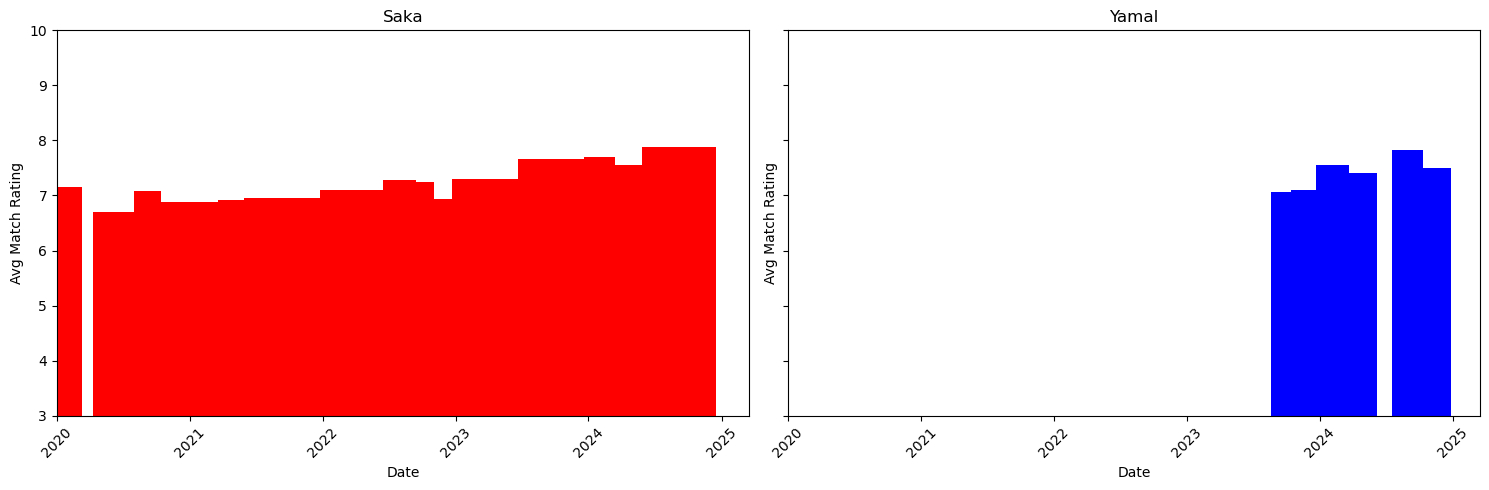

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

df = pd.read_csv('/Users/kieransullivan/sta141b/result_df.csv')

### Converting date columns to be in datetime
df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])

### Filtering just to Saka and Yamal
df = df[df["PlayerLastName"].str.lower().isin(["saka", "yamal"])]

### Colors
colors = {"saka": "red", "yamal": "blue"}

### Create two side by side plots from 2020 to today
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

x_min = pd.Timestamp("2020-01-01")
x_max = pd.Timestamp(datetime.today())

for ax, player in zip(axs, ["saka", "yamal"]):
    player_data = df[df["PlayerLastName"].str.lower() == player]
    for _, row in player_data.iterrows():
        ### Getting bar width
        duration = (row["end_date"] - row["start_date"]).days
        ### Plotting the vertical bars
        ax.bar(row["start_date"], row["avg_match_rating"], width=duration,
               align='edge', color=colors[player])
    
    ### Formatting of x-axis
    locator = mdates.AutoDateLocator(minticks=3, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis='x', rotation=45)
    ### Other formatting
    ax.set_title(player.capitalize())
    ax.set_xlabel("Date")
    ax.set_ylabel("Avg Match Rating")
    ax.set_ylim(3, 10)
    ax.set_xlim(x_min, x_max)

plt.tight_layout()

plt.savefig("/Users/kieransullivan/Downloads/match_ratings.png", dpi=300, bbox_inches="tight")

plt.show()

